# Pretraining Data Encoding

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-21 03:48:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.005s  

2025-02-21 03:48:03 (229 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [1]:
with open('input.txt', 'r') as f:
    text = f.read()
len(text)

1115394

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook's working directory is set such that ../llm-tokenizer is reachable:
tokenizer_dir = os.path.abspath(os.path.join(os.getcwd(), '../llm-tokenizer'))
if tokenizer_dir not in sys.path:
    sys.path.insert(0, tokenizer_dir)

import BPETokenizer  # Now you should be able to import it

In [3]:
tokenizer_vocab_size = 500

In [4]:
tokenizer = BPETokenizer.Tokenizer(text, encoding_vocab_size=tokenizer_vocab_size, raw_tokens=False)

In [5]:
assert False, "load from tokenizer.tokenizer.pickle instead"
from time import time
start = time()
tokenizer.train(debug=False)
end = time()
print(end - start)
print(tokenizer.mint_token)

AssertionError: load from tokenizer.tokenizer.pickle instead

In [6]:
tokenizer.load_from_file()

In [7]:
encoded_dataset = tokenizer.encode(text, raw_tokens=False)

In [8]:
len(encoded_dataset) / len(text)

0.4458684554516162

In [9]:
encoded_dataset[:10]

[70, 299, 296, 32, 1709, 984, 655, 538, 585, 111]

In [10]:
tokenizer.decode(encoded_dataset[:10], raw_tokens=False)

'First Citizen:\nBefore we pro'

In [11]:
for i in range(30):
    print(i, tokenizer.decode([999-i], raw_tokens=False))


0 itiz
1 urse
2 atch
3 ren
4 ness 
5 .

First 
6 wick
7 Rich
8 queen
9 na
10 ss
11 eal
12 pe
13 ry
14 that
15 Be
16 .

KING RICHARD I
17 day
18 ere is 
19 sc
20 rong
21 e?


22 ORIOLANUS:

23 old
24  shall 
25 cannot 
26  at 
27 ORIOLAN
28 ORIOL
29 friend


# Pretraining Data Preparation

In [15]:
import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available else 'cpu'

In [80]:
from GPT import GPT, GPTConfig

config = GPTConfig
config.batch_size = 32
config.block_size = 64
config.epochs = 10000
config.validation_frequency = 20
config.validation_epochs = 4

In [17]:
config.block_size

64

In [18]:
split = int(len(encoded_dataset) * 0.95)
split

472453

In [19]:
train_data =  torch.tensor(encoded_dataset[:split])
val_data = torch.tensor(encoded_dataset[split+config.block_size:])

In [24]:
def get_training_data(data, device=device):
    X, y, i = [], [], 0
    while i+1+config.block_size < len(data):
        if i % 50000 == 0 : print(i)
        X.append(data[i:i+config.block_size])
        y.append(data[i+1:i+1+config.block_size])
        i += 1
    X, y = torch.stack(X), torch.stack(y)
    X, y  = X.to(device), y.to(device)
    print(X.shape, y.shape)
    return X, y
    

In [25]:
X_tr, y_tr = get_training_data(train_data)

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
torch.Size([472388, 64]) torch.Size([472388, 64])


In [26]:
X_tr, y_tr

(tensor([[  70,  299,  296,  ...,  275,  267,   82],
         [ 299,  296,   32,  ...,  267,   82,  280],
         [ 296,   32, 1709,  ...,   82,  280,  403],
         ...,
         [ 594,  989,   32,  ...,  261,   66, 1014],
         [ 989,   32,  320,  ...,   66, 1014,  110],
         [  32,  320,   32,  ..., 1014,  110,  543]], device='cuda:0'),
 tensor([[ 299,  296,   32,  ...,  267,   82,  280],
         [ 296,   32, 1709,  ...,   82,  280,  403],
         [  32, 1709,  984,  ...,  280,  403, 1410],
         ...,
         [ 989,   32,  320,  ...,   66, 1014,  110],
         [  32,  320,   32,  ..., 1014,  110,  543],
         [ 320,   32, 1438,  ...,  110,  543,  275]], device='cuda:0'))

In [28]:
X_val, y_val = get_training_data(val_data)

0
torch.Size([24737, 64]) torch.Size([24737, 64])


# Training

In [29]:
def get_batch(X, y, batch_size):
    # assert X.shape[0] == y.shape[0]
    ix = torch.randint(0, X.shape[0], (batch_size,))
    return X[ix], y[ix]

In [30]:
_X, y = get_batch(X_tr, y_tr, config.batch_size)
X, y = get_batch(X_tr, y_tr, config.batch_size)
assert X[0][0] != _X[0][0]
X.shape, y.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [213]:
import torch

import gc
gc.collect()

#del X_tr
#del y_tr

l = locals().items()
for name, obj in l:
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            print(f"{name}: shape={obj.shape}, device={obj.device}")
    except Exception as e:
        pass
    


__: shape=torch.Size([]), device=cuda:0
X_val: shape=torch.Size([24737, 64]), device=cuda:0
y_val: shape=torch.Size([24737, 64]), device=cuda:0
_X: shape=torch.Size([32, 64]), device=cuda:0
y: shape=torch.Size([32, 64]), device=cuda:0
X: shape=torch.Size([32, 64]), device=cuda:0
logits: shape=torch.Size([1, 64, 50257]), device=cuda:0
_37: shape=torch.Size([32, 64, 50257]), device=cuda:0
_41: shape=torch.Size([32, 64]), device=cuda:0
_42: shape=torch.Size([2048, 50257]), device=cuda:0
_45: shape=torch.Size([]), device=cuda:0
_46: shape=torch.Size([]), device=cuda:0
train_loss: shape=torch.Size([]), device=cuda:0
_48: shape=torch.Size([]), device=cuda:0
val_loss: shape=torch.Size([]), device=cuda:0
x: shape=torch.Size([65]), device=cuda:0
_108: shape=torch.Size([14]), device=cuda:0
_110: shape=torch.Size([1, 14]), device=cuda:0
_111: shape=torch.Size([1, 14, 50257]), device=cuda:0
_119: shape=torch.Size([50257]), device=cuda:0
_121: shape=torch.Size([50257]), device=cuda:0
_122: shape=to

In [214]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Feb 21 06:51:10 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   43C    P8    15W / 140W |  15231MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [89]:
model = GPT(config)
model.to(device)
print(sum(p.numel() for p in model.parameters()))

162299904


In [100]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
train_losses, val_losses = [], []
bb = config.batch_size * config.block_size

for epoch in range(config.epochs):
    optimizer.zero_grad()
    X, y = get_batch(X_tr, y_tr, config.batch_size)
    logits = model(X)
    train_loss = F.cross_entropy(logits.view(bb, -1), y.view(bb))
    train_losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()
    
    
    if epoch % config.validation_frequency == 0:
        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            for _ in range(config.validation_epochs):
                X, y = get_batch(X_val, y_val, config.batch_size)
                logits = model(X)
                val_loss = F.cross_entropy(logits.view(bb, -1), y.view(bb))
                epoch_val_losses.append(val_loss)
            val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
            model.train()
    
    
  
            val_losses.append(val_loss)
            print(f"[{epoch}/{config.epochs}] train_loss={train_loss.item():.2f}, val_loss={val_loss:.2f}")

# [880/10000] train_loss=3.59, val_loss=4.00

[0/10000] train_loss=3.57, val_loss=3.97
[20/10000] train_loss=3.68, val_loss=4.04


KeyboardInterrupt: 

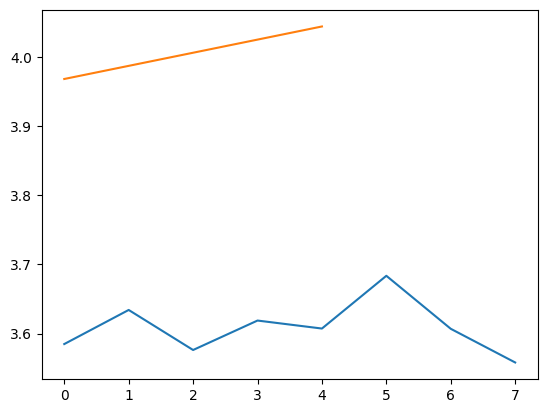

In [101]:
from matplotlib import pyplot as plt
gap = 4
plot_size = gap * len(val_losses)
val_losses = [t.cpu() for t in val_losses]
clip = (len(train_losses) // plot_size) * plot_size

plt.plot(torch.tensor(train_losses[:clip]).view(plot_size, - 1).mean(1))
plt.plot([i * gap for i, _ in enumerate(val_losses)], val_losses)
plt.show()

# Generation

In [188]:
prompt = " "
tokens = tokenizer.encode(prompt, raw_tokens=False)
tokens
model.eval()
x = torch.tensor(tokens[:config.block_size], device=device).view(1, -1)
x
    

tensor([[32]], device='cuda:0')

In [189]:
to_decode = x.tolist()[0]
for _ in range(500):
    
    x = x[-config.block_size:]

    logits = model(x.view(1, -1))
    
    new_token = torch.multinomial(F.softmax(logits[0, -1, :], dim=0),  1)
    v, ixs = logits[0, -1, :].topk(50)
    ix = torch.multinomial(F.softmax(v, dim=0), 1)
    new_token = ixs[ix]
    to_decode.append(new_token.view(-1).item())
    x = torch.cat([x.view(-1), new_token])

print(tokenizer.decode(to_decode, raw_tokens=False))

 unes of bratry arms they guk'd, in.

KING HENRY VI:
Can, how lorims good!

Second now, man:
First nothing, my lord by thy seve thore.
'Tis true that hason'd is be to dide is kinlnelk tharideed?

LEONTES:
Lest are your pas it: but I excesterntak to hese should all orself them!
I murp, by SON:
A more before his
country nor say'd flame, I will heard to vain!
You former grace, deempes widow his down when never shere,
If ithere is chan with is it fiel me,
Make bellaining the coward.

Pethle sindom you hontal king touch
And memust and a tion the is over buthow
Hereforry restrist him. I kneet
By hear's life,
As the princence it fling-would liberse that you and and stubirst thee?

LORY:
O, now Clow excus, in blead?

Were my hese birst now a which have thou not for here?

Pold now it Call missue,
Alauding.

LORICHARD III:
That a gentlemarsless plus, what why, that I welse Gontain the mayer the worl are dir should te thee bider.

A four generall, my so Feather:
But thou shalt not so.
What non, 

In [180]:
prompt = "First Citizen:"
tokens = tokenizer.encode(prompt, raw_tokens=False)
tokenizer.decode(tokens, raw_tokens=False)

'First Citizen:'

# Evaluation

In [201]:
X_val.shape, y_val.shape

(torch.Size([24737, 64]), torch.Size([24737, 64]))

In [215]:
samples = 20
y_pred = model(X_val[:samples])
y_pred = torch.argmax(F.softmax(y_pred, dim=2), dim=2)
y_val = y_val[:samples]
val, counts = torch.unique((y_pred == y_val).view(-1), return_counts=True)
assert val[1] == True
print(f"({samples * config.batch_size} samples) precision={counts[1] / (counts[0] + counts[1]).item():.3f}%")

(640 samples) precision=0.226%


In [ ]:
# (640 samples) precision=0.226%